In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from dahuffman import HuffmanCodec

In [2]:
df = pd.read_csv("filled/transact_18_22.csv")
df.set_index(['client', 'date'], inplace=True)
df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1]), level=1)
df = df.sort_index()
df

survival  socialization  self_realization  code
client  date                                                       
224     2019-01-03       1.0            0.0               0.0   1.0
        2019-01-04       0.0            0.0               0.0   0.0
        2019-01-05       1.0            0.0               0.0   1.0
        2019-01-06       1.0            1.0               0.0   3.0
        2019-01-07       1.0            0.0               0.0   1.0
...                      ...            ...               ...   ...
3564569 2019-12-10       1.0            0.0               0.0   1.0
        2019-12-11       1.0            0.0               0.0   1.0
        2019-12-12       1.0            0.0               0.0   1.0
        2019-12-13       1.0            0.0               0.0   1.0
        2019-12-14       1.0            0.0               0.0   1.0

[2760863 rows x 4 columns]

In [3]:
def compute_huffman_ratios(df: pd.DataFrame, columns: list):
    clients = df.index.get_level_values(0).unique()
    results = []

    for client in tqdm(clients, desc="Processing clients"):
        client_data = df.xs(client, level=0)
        row = {}

        for col in columns:
            seq = client_data[col].astype(str).tolist()

            codec = HuffmanCodec.from_data(seq)
            encoded = codec.encode(seq)
            original_size = len(seq) * 3
            compressed_size = len(encoded) * 8
            ratio = (compressed_size / original_size)

            row[f"huffman_ratio_{col}"] = ratio

        results.append(pd.Series(row, name=client))

    df_result = pd.DataFrame(results)
    df_result.index.name = "client"
    return df_result


In [4]:
huffman_df = compute_huffman_ratios(df, ["code"])
huffman_df

Processing clients: 100%|██████████| 8034/8034 [00:03<00:00, 2025.67it/s]


,huffman_ratio_code
client,
224,0.585742
1117,0.479227
1197,0.533333
1223,0.505345
1555,0.560999
...,...
3560436,0.527040
3561841,0.539499
3561945,0.471498


In [7]:
def plot_huffman_distributions(df_huffman):
    num_cols = len(df_huffman.columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, 4*num_cols))

    if num_cols == 1:
        axes = [axes]

    for ax, col in zip(axes, df_huffman.columns):
        sns.histplot(df_huffman[col], bins=30, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'Distribution of huffman_ratio', fontsize=14)
        ax.set_xlabel('Huffman Ratio')
        ax.set_ylabel('Clients')
        ax.set_xlim(0, max(df_huffman[col].max()*1.1, 1.0))

    plt.tight_layout()
    plt.show()

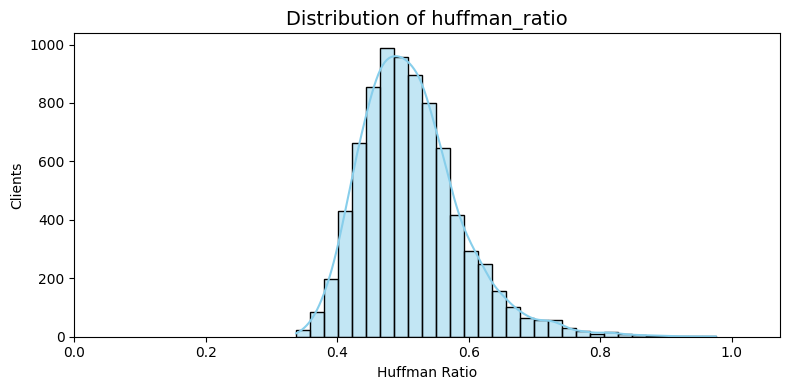

In [8]:
plot_huffman_distributions(huffman_df)